This notebook was adapted from one developed for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff).

# Deep learning for timeseries

## Different kinds of timeseries tasks

> A timeseries can be any data obtained via measurements at regular intervals, like the daily price of a stock, the hourly electricity consumption of a city, or the weekly sales of a store. Timeseries are everywhere, whether we’re looking at natural phenomena (like seismic activity, the evolution of fish populations in a river, or the weather at a location) or human activity patterns (like visitors to a website, a country’s GDP, or credit card transactions).
>
> — <cite>Deep Learning with Python, Second Edition by François Chollet</cite>

## A temperature-forecasting example

In this example, we will attempt to predict the temperature in 24 hours, based on a timeseries of hourly measurements of quantities such as atmospheric pressure and humidity. These measurements were taken from the Max Planck Institute for Biogeochemistry in Jena, Germany every 10 minutes over the period 2009-2016.

<cite>Adam Erickson and Olaf Kolle, www.bgc-jena.mpg.de/wetter.</cite>

In [1]:
! wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip -q
! unzip jena_climate_2009_2016.csv.zip

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


**Inspecting the data of the Jena weather dataset**

In [2]:
import os
fname = os.path.join('jena_climate_2009_2016.csv')

with open(fname) as f:
    data = f.read()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print('Lines of data:', len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
Lines of data: 420451


**Parsing the data**

Here we will covert all 420,551 lines of data into NumPy arrays: one for our target variable, temperature (in degrees Celsius) and another one for all other features in the data set. We will eliminate the 'Date Time' column.

In [4]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

**Plotting the temperature timeseries**

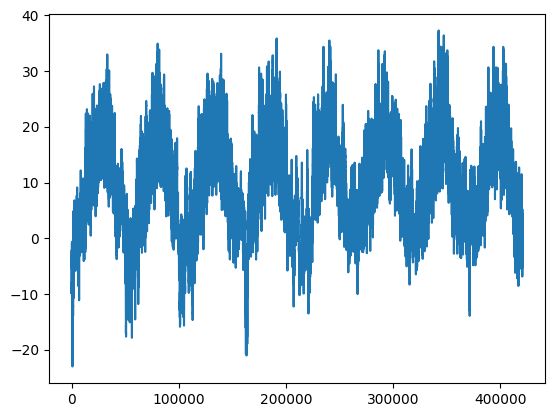

In [ ]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

**Plotting the first 10 days of the temperature timeseries**

There are 24 x 6 = 144 data points per day.

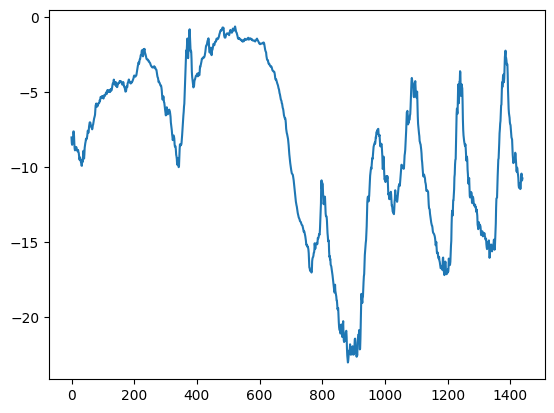

In [ ]:
plt.plot(range(1440), temperature[:1440])

**Computing the number of samples we'll use for each data split**

We will use 50% of data for training and 25% each for validation and testing.

Since our task is to predict the future given past data, it's important to make our test data the most recent in the time series.

In [5]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print('num_train_samples:', num_train_samples)
print('num_val_samples:', num_val_samples)
print('num_test_samples:', num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### Preparing the data

Problem statement: Given 5 days of data (measurements every hour), attempt to predict the temperature 24 hours later.

**Normalizing the data**

Our measurements are on different scales so we must normalize each feature independently.

In [6]:
# always use training data for this step
mean = raw_data[:num_train_samples].mean(axis = 0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis = 0)
raw_data /= std

In [7]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)

# a Keras utility for generating samples "on the fly"
# during training and prediction

dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data = int_sequence[:-3],
    targets = int_sequence[3:],
    sequence_length = 3,
    batch_size = 2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


**Instantiating datasets for training, validation, and testing**

In [8]:
# sample one data point per hour
sampling_rate = 6
# over 5 days
sequence_length = 120
# the target for each sequence is the temperature
# 24 hours after the end of the sequence
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    sequence_length=sequence_length,
    shuffle = True, # samples are randomly shuffled
    batch_size = batch_size,
    start_index = 0,
    end_index = num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle = True,
    batch_size = batch_size,
    start_index = num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle = True,
    batch_size = batch_size,
    start_index = num_train_samples + num_val_samples)

**Inspecting the output of one of our datasets**

In [ ]:
for samples, targets in train_dataset:
    print('samples shape:', samples.shape)
    print('targets shape:', targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


### A common-sense, non-machine-learning baseline

**Computing the common-sense baseline MAE**

A simple approach to the problem, before attempting a deep learning model, is to predict that the temperature 24 hours from now will be equal to the temperature right now.

We will use mean absolute error (MAE) as our evaluation metric.

In [ ]:
def evaluate_naive_method(dataset):
    total_abs_err = 0
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f'Validation MAE: {evaluate_naive_method(val_dataset):.2f}')
print(f'Test MAE: {evaluate_naive_method(test_dataset):.2f}')

Validation MAE: 2.44
Test MAE: 2.62


### A basic machine-learning model

**Training and evaluating a densely connected model**

In [9]:
from tensorflow import keras
from keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation = 'relu')(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# this step will save the best-performing model
# for evaluation on the test data set
callbacks = [
    keras.callbacks.ModelCheckpoint('jena_dense.keras',
                                    save_best_only = True)
]

model.compile(optimizer = 'rmsprop',
              loss = 'mse',
              metrics = ['mae'])

history = model.fit(train_dataset,
                    epochs = 10,
                    validation_data = val_dataset,
                    callbacks = callbacks)

model = keras.models.load_model('jena_dense.keras')
print(f'Test MAE: {model.evaluate(test_dataset)[1]:.2f}')

Epoch 1/10
819/819 [==============================] - 45s 48ms/step - loss: 13.9548 - mae: 2.8975 - val_loss: 12.0219 - val_mae: 2.7270
Epoch 2/10
819/819 [==============================] - 39s 47ms/step - loss: 10.0335 - mae: 2.4998 - val_loss: 10.4599 - val_mae: 2.5453
Epoch 3/10
819/819 [==============================] - 39s 47ms/step - loss: 9.1090 - mae: 2.3805 - val_loss: 11.6132 - val_mae: 2.7135
Epoch 4/10
819/819 [==============================] - 38s 46ms/step - loss: 8.5237 - mae: 2.2996 - val_loss: 10.8462 - val_mae: 2.5944
Epoch 5/10
819/819 [==============================] - 39s 47ms/step - loss: 8.1260 - mae: 2.2450 - val_loss: 11.5041 - val_mae: 2.6788
Epoch 6/10
819/819 [==============================] - 39s 47ms/step - loss: 7.8112 - mae: 2.2018 - val_loss: 12.5683 - val_mae: 2.8096
Epoch 7/10
819/819 [==============================] - 47s 57ms/step - loss: 7.5696 - mae: 2.1668 - val_loss: 10.1854 - val_mae: 2.5184
Epoch 8/10
819/819 [==============================] -

**Plotting results**

Showing the loss curves (MAE) for training and validation sets.

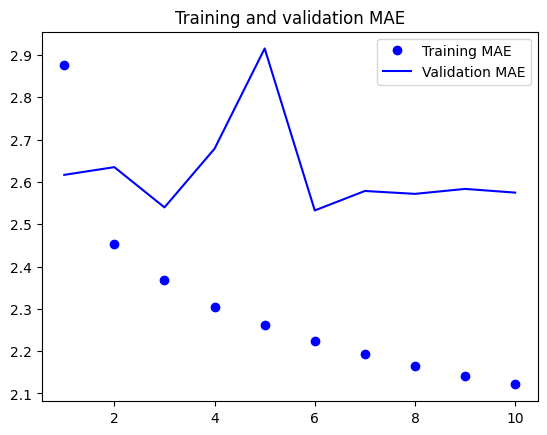

In [ ]:
import matplotlib.pyplot as plt
loss = history.history['mae']
val_loss = history.history['val_mae']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training MAE')
plt.plot(epochs, val_loss, 'b', label = 'Validation MAE')
plt.title('Training and validation MAE')
plt.legend()
plt.show()

Our common-sense baseline validation MAE is 2.44 degrees.

### Let's try a 1D convolutional model

One-dimensional convolutional networks rely on one-dimensional windows that "slide across" input sequences.

> You can thus build 1D convnets, strictly analogous to 2D convnets. They’re a great fit for any sequence data that follows the translation invariance assumption (meaning that if you slide a window over the sequence, the content of the window should follow the same properties independently of the location of the window).
>
> — <cite>Deep Learning with Python, Second Edition by François Chollet</cite>

In [10]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# the input window is 24, meaning we will look at 24 hours of data
x = layers.Conv1D(8, 24, activation = 'relu')(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation = 'relu')(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation = 'relu')(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint('jena_conv.keras',
                                    save_best_only = True)
]
model.compile(optimizer = 'rmsprop',
              loss = 'mse',
              metrics = ['mae'])

history = model.fit(train_dataset,
                    epochs = 10,
                    validation_data = val_dataset,
                    callbacks = callbacks)

model = keras.models.load_model('jena_conv.keras')
print(f'Test MAE: {model.evaluate(test_dataset)[1]:.2f}')

Epoch 1/10
819/819 [==============================] - 48s 50ms/step - loss: 22.6382 - mae: 3.7333 - val_loss: 16.0428 - val_mae: 3.2030
Epoch 2/10
819/819 [==============================] - 41s 49ms/step - loss: 15.6851 - mae: 3.1440 - val_loss: 15.8319 - val_mae: 3.1715
Epoch 3/10
819/819 [==============================] - 49s 59ms/step - loss: 14.1382 - mae: 2.9760 - val_loss: 13.3792 - val_mae: 2.8916
Epoch 4/10
819/819 [==============================] - 42s 51ms/step - loss: 13.1690 - mae: 2.8671 - val_loss: 14.1102 - val_mae: 2.9544
Epoch 5/10
819/819 [==============================] - 40s 49ms/step - loss: 12.4507 - mae: 2.7848 - val_loss: 14.7987 - val_mae: 3.0311
Epoch 6/10
819/819 [==============================] - 42s 51ms/step - loss: 11.9524 - mae: 2.7284 - val_loss: 13.0772 - val_mae: 2.8544
Epoch 7/10
819/819 [==============================] - 48s 59ms/step - loss: 11.5175 - mae: 2.6788 - val_loss: 13.5238 - val_mae: 2.9083
Epoch 8/10
819/819 [============================

The test MAE is much worse than our common-sense baseline. There are 2 issues:
1. Weather data violates our assumption of translation invariance, at least on the time scale we want to predict (weather at night is very different than weather in the morning).
2. Order matters, and our max pooling and global average pooling layers detroy order.

### A first recurrent baseline

**A simple LSTM-based model**

Let's try a single Long Short Term Memory (LSTM) layer.

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint('jena_lstm.keras',
                                    save_best_only = True)
]
model.compile(optimizer = 'rmsprop',
              loss = 'mse',
              metrics = ['mae'])

history = model.fit(train_dataset,
                    epochs = 10,
                    validation_data = val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model('jena_lstm.keras')
print(f'Test MAE: {model.evaluate(test_dataset)[1]:.2f}')

Epoch 1/10
819/819 [==============================] - 61s 70ms/step - loss: 44.7055 - mae: 4.8970 - val_loss: 13.5646 - val_mae: 2.8056
Epoch 2/10
819/819 [==============================] - 44s 53ms/step - loss: 11.1762 - mae: 2.6006 - val_loss: 10.0833 - val_mae: 2.4751
Epoch 3/10
819/819 [==============================] - 45s 54ms/step - loss: 9.9445 - mae: 2.4588 - val_loss: 10.0625 - val_mae: 2.4636
Epoch 4/10
819/819 [==============================] - 45s 55ms/step - loss: 9.4713 - mae: 2.3890 - val_loss: 9.5645 - val_mae: 2.4065
Epoch 5/10
819/819 [==============================] - 52s 63ms/step - loss: 9.1485 - mae: 2.3446 - val_loss: 10.1353 - val_mae: 2.4544
Epoch 6/10
819/819 [==============================] - 51s 62ms/step - loss: 8.8259 - mae: 2.3056 - val_loss: 9.5997 - val_mae: 2.4189
Epoch 7/10
819/819 [==============================] - 52s 63ms/step - loss: 8.5772 - mae: 2.2765 - val_loss: 9.5968 - val_mae: 2.4129
Epoch 8/10
819/819 [==============================] - 52

### A recurrent layer in Keras

**An RNN layer that can process sequences of any length**

By setting the `timesteps` parameter to `None`, we can process (batches of) sequences of arbitrary length. If sequence length varies in our data, this is helpful. If not, specifying `timesteps` might help performance.

In [ ]:
num_features = 14
inputs = keras.Input(shape = (None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

**An RNN layer that returns only its last output step**

Recurrent layers in Keras (`SimpleRNN`, `LSTM`, and `GRU`) can either return full sequences of successive outputs for each timestep or return on the last output for each input sequence.

In [ ]:
num_features = 14
steps = 120
inputs = keras.Input(shape = (steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences = False)(inputs)
print(outputs.shape)

(None, 16)


**An RNN layer that returns its full output sequence**

If we want to return outputs for each timestep, we set `return_sequences` to `True`. We'll want to do this in cases where we stack several recurrent layers one after the other, as in the next step.

In [ ]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences = True)(inputs)
print(outputs.shape)

(None, 120, 16)


**Stacking RNN layers**

In [ ]:
inputs = keras.Input(shape = (steps, num_features))
x = layers.SimpleRNN(16, return_sequences = True)(inputs)
x = layers.SimpleRNN(16, return_sequences = True)(x)
outputs = layers.SimpleRNN(16)(x)

>In practice, you’ll rarely work with the `SimpleRNN` layer. It’s generally too simplistic to be of real use. In particular, `SimpleRNN` has a major issue: although it should theoretically be able to retain at time `t` information about inputs seen many timesteps before, such long-term dependencies prove impossible to learn in practice. This is due to the **vanishing gradient** problem, an effect that is similar to what is observed with non-recurrent networks (feedforward networks) that are many layers deep: as you keep adding layers to a network, the network eventually becomes untrainable.
>
> — <cite>Deep Learning with Python, Second Edition by François Chollet</cite>

## Advanced use of recurrent neural networks

### Using recurrent dropout to fight overfitting

**Training and evaluating a dropout-regularized LSTM**

We can use dropout to mitigate overfitting, which we saw in our LSTM baseline earlier.

Since we're using dropout, we can increase the number of units in our `LSTM` layer from 16 to 32, allowing for a more expressive model without having to worry about overfitting. Since networks that use dropout take longer to converge, we need to train for longer, so we will increase the number of epochs to 50.

In [ ]:
inputs = keras.Input(shape = (sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout = 0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint('jena_lstm_dropout.keras',
                                    save_best_only = True)
]
model.compile(optimizer = 'rmsprop',
              loss = 'mse',
              metrics = ['mae'])

history = model.fit(train_dataset,
                    epochs = 50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/50
819/819 [==============================] - 456s 553ms/step - loss: 28.4242 - mae: 3.9363 - val_loss: 9.7873 - val_mae: 2.4350
Epoch 2/50
819/819 [==============================] - 425s 517ms/step - loss: 14.8679 - mae: 2.9946 - val_loss: 9.5399 - val_mae: 2.4039
Epoch 3/50
819/819 [==============================] - 451s 550ms/step - loss: 13.9417 - mae: 2.8972 - val_loss: 9.3773 - val_mae: 2.3743
Epoch 4/50
819/819 [==============================] - 392s 478ms/step - loss: 13.2622 - mae: 2.8255 - val_loss: 9.3895 - val_mae: 2.3702
Epoch 5/50
819/819 [==============================] - 382s 467ms/step - loss: 12.7913 - mae: 2.7769 - val_loss: 9.1062 - val_mae: 2.3372
Epoch 6/50
819/819 [==============================] - 376s 458ms/step - loss: 12.4511 - mae: 2.7360 - val_loss: 9.3591 - val_mae: 2.3730
Epoch 7/50
551/819 [===================>..........] - ETA: 1:54 - loss: 12.1234 - mae: 2.6979

In [ ]:
inputs = keras.Input(shape = (sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout = 0.2, unroll = True)(inputs)

### Stacking recurrent layers

**Training and evaluating a dropout-regularized, stacked GRU model**

In [ ]:
inputs = keras.Input(shape = (sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout = 0.5, return_sequences = True)(inputs)
x = layers.GRU(32, recurrent_dropout = 0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint('jena_stacked_gru_dropout.keras',
                                    save_best_only = True)
]

model.compile(optimizer = 'rmsprop',
              loss = 'mse',
              metrics = ['mae'])

history = model.fit(train_dataset,
                    epochs = 50,
                    validation_data = val_dataset,
                    callbacks = callbacks)

model = keras.models.load_model('jena_stacked_gru_dropout.keras')
print(f'Test MAE: {model.evaluate(test_dataset)[1]:.2f}')

### Using bidirectional RNNs

>A bidirectional RNN exploits the order sensitivity of RNNs: it uses two regular RNNs, such as the `GRU` and `LSTM` layers you’re already familiar with, each of which processes the input sequence in one direction (chronologically and antichronologically), and then merges their representations. By processing a sequence both ways, a bidirectional RNN can catch patterns that may be overlooked by a unidirectional RNN.
>
> — <cite>Deep Learning with Python, Second Edition by François Chollet</cite>

**Training and evaluating a bidirectional LSTM**

We will not run this example since we expect it to significantly underperform previous models. This is because temperature data is inherently chronological (more recent weather is a better predictor than past weather for our problem), but there are use cases, such as natural language processing, for which a bidirectional LSTM can improve performance.

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

### Going even further

>There are many other things you could try in order to improve performance on the temperature-forecasting problem:
>
>- Adjust the number of units in each recurrent layer in the stacked setup, as well as the amount of dropout. The current choices are largely arbitrary and thus probably suboptimal.
>
>- Adjust the learning rate used by the RMSprop optimizer, or try a different optimizer.
>
>- Try using a stack of Dense layers as the regressor on top of the recurrent layer, instead of a single Dense layer.
>
>- Improve the input to the model: try using longer or shorter sequences or a different sampling rate, or start doing feature engineering.
>
> — <cite>Deep Learning with Python, Second Edition by François Chollet</cite>